<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/experiment/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Download the files '''
'''Only for colab'''
useColab = True
useDrive = True

if useColab:
    !wget https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/experiment.zip
    !unzip experiment.zip
    #!find continual-learning-ait-experiment -type f ! -name "main.ipynb" -exec cp {} . \;
    !cd continual-learning-ait-experiment

    import sys
    sys.path.append('/content/continual-learning-ait-experiment')

    if useDrive:
        from google.colab import drive
        drive.mount('/content/drive')
        encoder_f = '/drive/MyDrive/continual-learning-ait/checkpoints/32x32_classifier.pt'
        scorenet_f = 'drive/MyDrive/continual-learning-ait/checkpoints/edm-cifar10-32x32-cond-vp.pkl'
    else:
        !wget https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl

       !wget https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/32x32_classifier.pt

--2023-05-15 15:46:05--  https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/experiment.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/experiment [following]
--2023-05-15 15:46:05--  https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/experiment
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘experiment.zip’

experiment.zip          [ <=>                ]   1.62M  --.-KB/s    in 0.1s    

2023-05-15 15:46:05 (16.7 MB/s) - ‘experiment.zip’ saved [1703633]

Archive:  experiment.zip
33be9feb84db205993049252d9cce46db0ed1dbd
  

In [2]:
import numpy as np
import tensorflow as tf
import keras

import torch
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from keras.metrics import Accuracy

#import classifier
import generator
from classifier import Classifier
import utils
from data_preparation import load_dataset, CLDataLoader, RealFakeConditionalDataset

import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import importlib

# Load the dataset

In [3]:
dpt_train, dpt_test = load_dataset('cifar-10', n_classes_first_task=4, n_classes_other_task=3)

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
batch_size = 256
train_loader = CLDataLoader(dpt_train, batch_size , train=True)
test_loader = CLDataLoader(dpt_test, batch_size, train=False)

# Define parameters and agent

In [23]:
params = {
    #general
    "n_runs": 1,
    "n_tasks": 3,
    "n_classes": 10,
    "input_shape": (32, 32, 3),
    "embedding_shape": (6, 6, 8),
    "samples_per_task": 10000,
    "batch_size": batch_size,
    "eval_batch_size": 1,
    "print_every": 1,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "img_resolution": 32,

    #classifier
    "cls_iters": 1,
    "cls_lr": 1e-2,
    "cls_epochs": 5,

    #generator
    "gen_epochs": 2,
    "gen_lr": 3e-4,

    #mir
    "n_mem": 2,
    "mir_iters": 3,
    "reuse_samples": True,
    "mem_coeff": 0.12,
    "z_size": 10,
    
    "gen_ent_coeff": 0.5,
    "gen_div_coeff": 0.5,
    "gen_shell_coeff": 0.5,
    "cls_xent_coeff": 0.5,
    "cls_ent_coeff": 0.5,
    "cls_div_coeff": 0.5,
    "cls_shell_coeff": 0.5,
}

In [6]:
'''Agent to handle models, parameters and states'''

class Agent:
  def __init__(self, hparams):
    self.params = hparams
    self.state = dict()

    self.classifier = None
    self.generator = None

    self.optimizer = None
    self.optimizer_gen = None

    self.loss = None
    self.loss_gen = None

    self.eval = accuracy_score


  def set_models(
          self,
          _generator=None,
          _classifier=None,
    ):
    cls = _classifier #classifier
    gen = _generator  #generator

    # optimizers
    self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=params["cls_lr"])
    self.optimizer_gen = torch.optim.Adam(agent.generator.discriminator.parameters(), lr=agent.params["gen_lr"], weight_decay=1e-7)

    # losses
    self.loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    self.loss_gen = torch.nn.BCELoss()

    # classifier pipeline
    data_input = keras.Input(shape=self.params["input_shape"], name="image")
    cls_output = cls(data_input)
    self.classifier = keras.Model(inputs=data_input, outputs=cls_output)
    self.classifier.compile(optimizer=self.optimizer, loss=self.loss, metrics=["accuracy"])

    # generator pipeline
    self.generator = gen

# Functions for training

In [7]:
'''Generate samples and train the diffusion model at the same time'''

def generate(
        agent,
        num_samples,
        dg_weight_1st_order=1,
        dg_weight_2nd_order=0,
        boosting = 1,
        time_min= 0.01, time_max= 1,
        class_idx=None,
):
    # Pick latents and labels.
    latents = torch.randn([num_samples, agent.generator.net.img_channels, agent.params["img_resolution"], agent.params["img_resolution"]], device=agent.params['device'])

    class_labels = torch.eye(agent.params['n_classes'], device=agent.params['device'])[torch.randint(len(agent.state['classes_learned'])+1, size=[num_samples], device=agent.params['device'])]
    if class_idx is not None:
        class_labels[:, :] = 0
        class_labels[:, class_idx] = 1

    # Generate images.
    images = agent.generator.sample(boosting, time_min, time_max, dg_weight_1st_order, dg_weight_2nd_order, latents, class_labels)
    images = torch.transpose(images, 1, 3)
    images = torch.transpose(images, 1, 2)
    images, class_labels = images.cpu(), class_labels.cpu()
    images, class_labels = images.numpy(), class_labels.numpy()
    return images, class_labels


In [8]:
'''Retrive maximally interferred latent vector for classifier'''

def retrieve_mir(agent, samples, target):


    virtual_cls = Classifier()
    virtual_cls = utils.get_next_step_cls(
        agent.cls,
        virtual_cls,
        samples,
        target
    )

    final_generated = None
    final_labels = None
    for i in range(agent.params["n_mem"]):

        generated, labels = generate(agent, agent.params["batch_size"])

        for j in range(params["mir_iters"]):
            with tf.GradientTape(persistent=True) as tape:

                tape.watch(generated)

                y_pre = agent.classifier(generated)
                y_virtual = virtual_cls(generated)

                # maximise the interference:
                XENT = tf.constant(0.)
                if params["cls_xent_coeff"] > 0.:
                    XENT = tf.keras.losses.categorical_crossentropy(y_virtual, y_pre)

                # the predictions from the two models should be confident
                ENT = tf.constant(0.)
                if params["cls_ent_coeff"] > 0.:
                    ENT = tf.keras.losses.categorical_crossentropy(y_pre, y_pre)

                # the new-found samples should be different from each others
                DIV = tf.constant(0.)
                if params["cls_div_coeff"] > 0.:
                    for found_generated in range(i):
                        DIV += tf.keras.losses.MSE(
                            generated,
                            final_generated[found_generated * generated.shape[0]:found_generated * generated.shape[0] + generated.shape[0]]
                        ) / i

                # (NEW) stay on gaussian shell loss:
                SHELL = tf.constant(0.)
                if params["cls_shell_coeff"] > 0.:
                    SHELL = tf.keras.losses.MSE(
                        tf.norm(generated, axis=1),
                        tf.ones_like(tf.norm(generated, axis=1))*np.sqrt(params["z_size"])
                    )

                XENT, ENT, DIV, SHELL = \
                    tf.reduce_mean(XENT), \
                        tf.reduce_mean(ENT), \
                        tf.reduce_mean(DIV), \
                        tf.reduce_mean(SHELL)

                gain = params["cls_xent_coeff"] * XENT + \
                       -params["cls_ent_coeff"] * ENT + \
                       params["cls_div_coeff"] * DIV + \
                       -params["cls_shell_coeff"] * SHELL

            gen_grad = tape.gradient(gain, generated)
            if gen_grad is not None:
                generated = (generated + 1 * gen_grad)

        if final_generated is None:
            final_generated = generated.numpy().copy()
            final_labels = labels.numpy().copy()
        else:
            final_generated = np.concatenate([final_generated, generated.numpy().copy()])
            final_labels = np.concatenate([final_labels, labels.numpy().copy()])

    tf.stop_gradient(final_generated)

    return final_generated, final_labels

In [24]:
'''Train the generator unit'''

def train_generator(agent, real_fake_loader):
    scaler = lambda x: 2. * x - 1.

    # Training
    outs = []
    cors = []
    for data in real_fake_loader:
        agent.optimizer_gen.zero_grad()

        inputs, labels, cond = data
        cond = cond.to(agent.params["device"])
        inputs = inputs.to(agent.params["device"])
        labels = labels.to(agent.params["device"])
        inputs = scaler(inputs)

        # Data perturbation
        t, _ = agent.generator.vpsde.get_diffusion_time(inputs.shape[0], inputs.device)
        mean, std = agent.generator.vpsde.marginal_prob(t)
        z = torch.randn_like(inputs)
        perturbed_inputs = mean[:, None, None, None] * inputs + std[:, None, None, None] * z

        # Forward
        with torch.no_grad():
            pretrained_feature = agent.generator.encoder(perturbed_inputs, timesteps=t, feature=True).type(torch.cuda.FloatTensor)
        label_prediction = agent.generator.discriminator(pretrained_feature, t, sigmoid=True, condition=cond).view(-1)

        # Backward
        out = agent.loss_gen(label_prediction, labels)
        out.backward()
        agent.optimizer_gen.step()

        # Report
        cor = ((label_prediction > 0.5).float() == labels).float().mean()
        agent.state["epoch_eval"]["correction_rate"][-1].append(out.item())
        agent.state["epoch_eval"]["discriminator_loss"][-1].append(cor.item())

In [11]:
'''Train the encoder and the classifier unit'''
#lehet keverni kéne a mintákat

def train_classifier(agent):

    mem_x, mem_y = None, None

    for it in range(agent.params["cls_iters"]):
        history = agent.classifier.fit(data, target, batch_size=agent.params["batch_size"], epochs=1, verbose=0)
        if agent.state["task"] > 0:
            if it == 0 or not agent.params["reuse_samples"]:
                mem_x, mem_y = retrieve_mir(agent, agent.state["data"], agent.state["target"])

            if mem_x is not None:
                mem_history = agent.classifier.fit(mem_x, mem_y, batch_size=agent.params["batch_size"], epochs=1, verbose=1)

                agent.state["epoch_eval"]["retr_cls_loss"][-1].append(mem_history.history["loss"][0])
                agent.state["epoch_eval"]["retr_cls_accuracy"][-1].append(mem_history.history["accuracy"][0])
        agent.state["epoch_eval"]["cls_loss"][-1].append(history.history["loss"][0])
        agent.state["epoch_eval"]["cls_acc"][-1].append(history.history["accuracy"][0])

In [12]:
'''Run an epoch'''

def run_cls_epoch(agent):

    print(f"Running Task {agent.state['task']}, Epoch: {agent.state['epoch']} on Classifier")

    agent.state["eval"]["cls_loss"].append([])
    agent.state["eval"]["cls_acc"].append([])
    agent.state["eval"]["retr_cls_loss"].append([])
    agent.state["eval"]["retr_cls_accuracy"].append([])

    for i, (data, target) in enumerate(agent.state["tr_loader"]):
        agent.state["data"] = data
        agent.state["target"] = target
        train_classifier(agent)

    '''Evaluate the models in epoch'''
    if agent.state["epoch"] % agent.params["print_every"] == 0:
        print(f"    Classifier loss: {np.mean(agent.state['epoch_eval']['cls_loss'][-1])}"
              f"    Classifier accuracy: {np.mean(agent.state['epoch_eval']['cls_acc'][-1])}"
              f"    Retrieval loss: {np.mean(agent.state['epoch_eval']['retr_cls_loss'][-1])}"
              f"    Retrieval accuracy: {np.mean(agent.state['epoch_eval']['retr_cls_accuracy'][-1])}")

In [25]:
'''Run an epoch'''

def run_gen_epoch(agent):
  
    print(f"Running Task {agent.state['task']}, Epoch: {agent.state['epoch']} on Generator")
    
    agent.state["eval"]["discrimination_loss"].appen([])
    agent.state["eval"]["correction_rate"].append([])


    fake_samples, fake_labels = generate(
        agent, len(agent.state["tr_loader"]) , dg_weight_1st_order=0 ,dg_weight_2nd_order=0, boosting=0 )
    real_samples, real_labels = [], []
    for sample, label in agent.state["tr_loader"]:
        real_samples.append(sample.numpy())
        real_labels.append(label.numpy())
    real_samples, real_labels = np.concatenate(real_samples, axis=0), np.concatenate(real_labels, axis=0)

    train_data = np.concatenate((real_samples, fake_samples))
    train_label = torch.zeros(train_data.shape[0])
    train_label[:real_samples.shape[0]] = 1.
    transform = transforms.Compose([transforms.ToTensor()])
    condition_label = np.concatenate((real_labels, fake_labels))
    train_dataset = RealFakeConditionalDataset(train_data, train_label, condition_label, transform)

    real_fake_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=agent.params["batch_size"], shuffle=True)
    train_generator(agent, real_fake_loader)
    

    '''Evaluate the models in epoch'''
    if agent.state["epoch"] % agent.params["print_every"] == 0:
        print(f"    Discriminator loss: {np.mean(agent.state['epoch_eval']['discrimination_loss'][-1])}"
              f"    Correction rate: {np.mean(agent.state['epoch_eval']['correction_rate'][-1])}")

In [14]:
'''Run a task'''

def run_task(agent):

    agent.state["mir_tries"], agent.state["mir_success"] = 0, 0
    agent.state["epoch_eval"] = dict()


    for epoch in range(agent.params["cls_epochs"]):
        agent.state["epoch"] = epoch
        run_cls_epoch(agent)

    for epoch in range(agent.params["gen_epochs"]):
        agent.state["epoch"] = epoch
        run_gen_epoch(agent)

    '''Evaluate forgetting'''
    if (agent.state['task']) > 0:
      print("Evaluate Task: ", agent.state["task"])
    for i in range(agent.state["task"]+1):
        task_loss = []
        task_accuracy = []
        for data, target in test_loader[i]:
            logits = agent.classifier(data)
            #loss
            loss = agent.loss(logits, target)
            task_loss.append(np.mean(loss))
            #accuracy
            pred = np.argmax(logits, axis=1)
            y = np.argmax(target, axis=1)
            accuracy = agent.eval(y, pred)
            task_accuracy.append(accuracy)
        print(f"    Task {agent.state['task']} forgetting on task {i} : "
              f"        Loss: {np.mean(task_loss)}"
              f"        ACC: {np.mean(task_accuracy)}")

In [15]:
'''Run the experiment'''

def run(agent):
    agent.state["classes_learned"] = []
    agent.state["eval"]["cls_loss"] = []
    agent.state["eval"]["cls_acc"] = []
    agent.state["eval"]["retr_cls_loss"] = []
    agent.state["eval"]["retr_cls_accuracy"] = []
    agent.state["eval"]["discrimination_loss"] = []
    agent.state["eval"]["correction_rate"] = []
    for r in range(agent.params["n_runs"]):
        agent.state["run"] = r
        print(f"Run {r}")
        for task, (tr_loader, ts_loader) in enumerate(zip(train_loader, test_loader)):
            agent.state["task"] = task
            agent.state["tr_loader"] = tr_loader
            agent.state["ts_loader"] = ts_loader
            run_task(agent)
            #agent.state["classes_learned"].append(task)

# Training

In [26]:
encoder_f = '/drive/MyDrive/continual-learning-ait/checkpoints/32x32_classifier.pt'

agent = Agent(params)
agent.set_models(
    _classifier=Classifier(),
    _generator=generator.Generator(encoder_path=encoder_f),
)
#run(agent)

In [27]:
import pickle




In [28]:
agent.generator.set_score_network(scorenet)

In [29]:
run(agent)

Run 0
Running Task 0, Epoch: 0 on Generator
BCE loss: 0.06476288769094242, correction rate: 0.9845074152542372
Running Task 0, Epoch: 1 on Generator
BCE loss: 0.02415868822658845, correction rate: 0.9960655105316033
Running Task 0, Epoch: 2 on Generator
BCE loss: 0.02085156907856275, correction rate: 0.99609375
Running Task 0, Epoch: 3 on Generator
BCE loss: 0.020070268125352213, correction rate: 0.99609375
Running Task 0, Epoch: 4 on Generator
BCE loss: 0.01850671491041085, correction rate: 0.9960513902922808
Running Task 1, Epoch: 0 on Generator
BCE loss: 0.016691895297844893, correction rate: 0.99638671875
Running Task 1, Epoch: 1 on Generator
BCE loss: 0.012128880593809298, correction rate: 0.99775390625
Running Task 1, Epoch: 2 on Generator
BCE loss: 0.013780273688098532, correction rate: 0.997265625
Running Task 1, Epoch: 3 on Generator
BCE loss: 0.012609703063208143, correction rate: 0.99736328125
Running Task 1, Epoch: 4 on Generator
BCE loss: 0.013398111145943404, correction r

In [63]:
images = generate(agent, 1, 0.01, 1, 1, 0, 10, 4)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def disp(image):
    image = (image + 1)* 127.5

    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

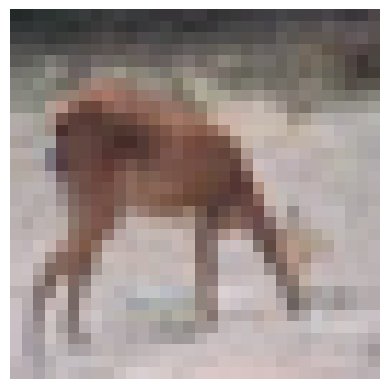

In [67]:
disp(images[0][1])

# Evaluation, testing

In [ ]:
def evaluate(loader, first_n_tasks=None):
    for task, tr_loader in enumerate(loader):
        print("Task: ", task)
        data, target = tr_loader.batch(124)
        logits = agent.classifier_model(data)
        pred = np.argmax(logits, axis=1)
        report = agent.eval(np.argmax(target, axis=1), pred)
        loss = tf.keras.losses.categorical_crossentropy(target, logits)
        print(report)
        print("Mean loss: ", np.mean(loss))

In [ ]:
print("Evaluation on training set:")
evaluate(train_loader)
print("Evaluation on test set:")
evaluate(test_loader)

# Utils for development

In [20]:
# Reload modules
importlib.reload(generator)

<module 'generator' from '/content/continual-learning-ait-experiment/generator.py'>

In [28]:
# Garbage collection
gc.collect()

59341